In [ ]:
!nvidia-smi

Sun Nov 20 11:40:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install segmentation_models -q

     |████████████████████████████████| 50 kB 6.5 MB/s 


In [ ]:
import os
import time
import shutil
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import numpy as np
import json
from tensorflow import keras as K
import nibabel as nib
import datetime
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import matplotlib.pyplot as plt
import segmentation_models as sm

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# seed all to reduce randomness
def seed_all(seed = 13):
    #torch.manual_seed(seed)
    #torch.cuda.manual_seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    print("Seed set to", seed)

seed_all()

Seed set to 13


## Dataset and Dataloader

In [ ]:
def get_filelist(data_path, seed=13, split=0.85):
    """
    Get the paths for all samples
    """
    json_f = os.path.join(data_path, "dataset.json")

    try:
        with open(json_f, "r") as fp:
            data = json.load(fp)
    except IOError as e:
        raise Exception("File {} doesn't exist!".format(    ))

    # Pring the summary of data from json
    print("*" * 26)
    print("=" * 26)
    print("Dataset name:        ", data["name"])
    print("Dataset description: ", data["description"])
    print("Tensor image size:   ", data["tensorImageSize"])
    print("=" * 26)
    print("*" * 26)

    """
	  Separate into train, test and validation by shuffling the dataset
	  """
    # Random seed is always to get the same outpus
    np.random.seed(seed)

    numFiles = data["numTraining"]
    idx_list = np.arange(numFiles) 
    # Shuffle the indices to randomize each dataset
    np.random.shuffle(idx_list) 
    # end of the training files
    train_idx = int(np.floor(numFiles*split)) 
    train_list = idx_list[:train_idx]
    other_list = idx_list[train_idx:]
    num_other = len(other_list)
    # index for the end of the testing files
    other_idx = num_other//2  
    valid_list = other_list[:other_idx]
    test_list = other_list[other_idx:]

    trainFiles = []
    # set everythin into the list
    for idx in train_list:
        f = os.path.join(data_path, data["training"][idx]["label"])
        f = data_path + f
        trainFiles.append(f)
    validateFiles = []
    for idx in valid_list:
        f = os.path.join(data_path, data["training"][idx]["label"])
        f = data_path + f
        validateFiles.append(f)
    testFiles = []
    for idx in test_list:
        f = os.path.join(data_path, data["training"][idx]["label"])
        f = data_path + f      
        testFiles.append(f)

    print("Number of training files   = {}".format(len(train_list)))
    print("Number of validation files = {}".format(len(valid_list)))
    print("Number of testing files    = {}".format(len(test_list)))

    return trainFiles, validateFiles, testFiles

In [ ]:
data_path = "/gdrive/My Drive/Kwork/Task05_Prostate/"

trainFiles, validFiles, testFiles = get_filelist(data_path=data_path, seed=13, split=0.8)

**************************
Dataset name:         PROSTATE
Dataset description:  Prostate transitional zone and peripheral zone segmentation
Tensor image size:    4D
**************************
Number of training files   = 25
Number of validation files = 3
Number of testing files    = 4


In [ ]:
class DatasetGenerator(Sequence):
    """
    TensorFlow Dataset for training
    """

    def __init__(self, filenames, batch_size=8, crop=True, crop_dim=[240,240], augment=False):
        img = np.array(nib.load(filenames[0]).dataobj)
        self.slice_dim = 2 # where the depth is present
        self.num_channels = 2 # channles that the data has
        self.num_slices_per_scan = img.shape[self.slice_dim]  
        self.filenames = filenames
        self.batch_size = batch_size
        self.augment = augment      
        if not crop:
            crop_dim[0] = img.shape[0]
            crop_dim[1] = img.shape[1]
        self.crop_dim = crop_dim  
        self.num_files = len(self.filenames)
        self.ds = self.get_dataset()

    def preprocess(self, img, label):
        """
        Normalize image
        Predict whole tumour in label
        """
        img = (img - img.mean()) / img.std()
        label[label > 0] = 1.0 
        return img, label

    def augment_data(self, img, msk):
        """
        Apply augmentation
        """
        # flip
        p = np.random.rand()
        if p > 0.5:
            ax = np.random.choice([0,1])
            img = np.flip(img, ax)
            msk = np.flip(msk, ax)
        # rotate
        p = np.random.rand()
        if p > 0.5:
            rot = np.random.choice([1, 2, 3])  
            img = np.rot90(img, rot, axes=[0,1])  
            msk = np.rot90(msk, rot, axes=[0,1])
        return img, msk
        
    def crop(self, img, msk):
        """
        crop the image and mask with random probability
        """
        slices = []
        random_prob = self.augment and np.random.rand() > 0.5

        for idx, idy in enumerate(range(self.num_channels)):
            crop_len, img_len = self.crop_dim[idx], img.shape[idy]
            start = (img_len-crop_len)//2
            # the offset from the sample
            offset = int(np.floor(start*0.20))
            if offset > 0 and random_prob:
                start += np.random.choice(range(-offset, offset))
                if ((start + crop_len) > img_len):
                    start = (img_len-crop_len)//2
            else:
                start = 0
            slices.append(slice(start, start+crop_len))
        return img[tuple(slices)], msk[tuple(slices)]

    def get_dataset(self):
        """
        Get the input, slice it acros the dimension and construct dataset out of it
        """ 
        idx = 0
        idy = 0
        while True:
            image_num = 1 + self.batch_size // self.num_slices_per_scan  
            
            for idz in range(image_num):
                label_filename = self.filenames[idx]
                label = np.array(nib.load(label_filename).dataobj)

                img_filename   = label_filename.replace("labelsTr", "imagesTr")
                img = np.array(nib.load(img_filename).dataobj)
                img = img[:,:,:,0]

                img, label = self.preprocess(img, label)
                img, label = self.crop(img, label)

                if idz == 0:
                    img_stack = img
                    label_stack = label
                else:
                    # concatenate to existing slices
                    img_stack = np.concatenate((img_stack,img), axis=self.slice_dim)
                    label_stack = np.concatenate((label_stack,label), axis=self.slice_dim)
                
                idx += 1 
                if idx >= len(self.filenames):
                    idx = 0
                    # shuufle for next iterations
                    np.random.shuffle(self.filenames)
            
            img = img_stack
            label = label_stack

            num_slices = img.shape[self.slice_dim]
            if self.batch_size > num_slices:
                raise Exception("batch size {} is too big for this data".format(self.batch_size, num_slices))
            
            # We have to randomize the stack to get different slices
            if self.augment:
                slice_i = np.random.choice(range(num_slices), num_slices)
                img = img[:,:,slice_i] 
                label = label[:,:,slice_i]
              
            if (idy + self.batch_size) < num_slices:
                img_batch, label_batch = img[:, :, idy:idy+self.batch_size], label[:, :, idy:idy+self.batch_size]   
            else:
                img_batch, label_batch = img[:,:,-self.batch_size:], label[:,:,-self.batch_size:]
            
            # apply augmentations
            if self.augment:
                img_batch, label_batch = self.augment_data(img_batch, label_batch)
                
            if len(np.shape(img_batch)) == 3:
                img_batch = np.expand_dims(img_batch, axis=-1)
            if len(np.shape(label_batch)) == 3:
                label_batch = np.expand_dims(label_batch, axis=-1)
                
            yield np.transpose(img_batch, [2,0,1,3]).astype(np.float32), np.transpose(label_batch, [2,0,1,3]).astype(np.float32)
            
            # more iterations
            idy += self.batch_size
            if idy >= num_slices:
                idy = 0
                idx += 1
            if idx >= len(self.filenames):
                idx = 0
                np.random.shuffle(self.filenames)
                
    def get_shape(self):
        """
        Get image and mask shapes
        """
        return [self.crop_dim[0], self.crop_dim[1], 1], [self.crop_dim[0], self.crop_dim[1], 1]

    def __len__(self):
        """
        Get the length of bathces
        """
        return (self.num_slices_per_scan * self.num_files)//self.batch_size

    def __getitem__(self, idx):
        """
        Get next data
        """
        return next(self.ds)


In [ ]:
ds_train = DatasetGenerator(trainFiles, augment=True)

ds_validation = DatasetGenerator(validFiles, augment=False)
    
ds_test = DatasetGenerator(testFiles, augment=False)

## Models

In [ ]:
class unet(object):
    """
    2D U-Net model complete class
    Decoding is done by either upsampling or transposed convolution.
    Choosen by upsampling_mode
    """

    def __init__(self, fms=16, upsampling_mode=False):
        """
        shape = (N,H,W,C) 
        """
        self.concat_axis = -1
        self.data_format = "channels_last"

        self.fms = fms
        K.backend.set_image_data_format(self.data_format)
        self.upsampling_mode = upsampling_mode


    def build_model(self, imgs_shape, msks_shape,
                   dropout=0.2):
        """
        U-Net Model
        Reference: https://arxiv.org/abs/1505.04597

        """

        self.input_shape = imgs_shape

        self.num_input_channels = imgs_shape[self.concat_axis]

        inputs = K.layers.Input(self.input_shape, name="MRImages")

        # For Convolution 
        params = dict(kernel_size=(3, 3), activation="relu",
                      padding="same",
                      kernel_initializer="he_uniform")

        # For Transposed Convolution
        params_trans = dict(kernel_size=(2, 2), strides=(2, 2),
                            padding="same")

        encode1 = K.layers.Conv2D(filters=self.fms, **params)(inputs)
        encode1 = K.layers.Conv2D(filters=self.fms, **params)(encode1)
        pool1 = K.layers.MaxPooling2D(pool_size=(2, 2))(encode1)

        encode2 = K.layers.Conv2D(filters=self.fms*2, **params)(pool1)
        encode2 = K.layers.Conv2D(filters=self.fms*2, **params)(encode2)
        pool2 = K.layers.MaxPooling2D(pool_size=(2, 2))(encode2)

        encode3 = K.layers.Conv2D(filters=self.fms*4, **params)(pool2)
        encode3 = K.layers.SpatialDropout2D(dropout)(encode3)
        encode3 = K.layers.Conv2D(filters=self.fms*4, **params)(encode3)
        pool3 = K.layers.MaxPooling2D(pool_size=(2, 2))(encode3)

        encode4 = K.layers.Conv2D(filters=self.fms*8, **params)(pool3)
        encode4 = K.layers.SpatialDropout2D(dropout)(encode4)
        encode4 = K.layers.Conv2D(filters=self.fms*8, **params)(encode4)
        pool4 = K.layers.MaxPooling2D(pool_size=(2, 2))(encode4)

        encode5 = K.layers.Conv2D(filters=self.fms*16, **params)(pool4)
        encode5 = K.layers.Conv2D(filters=self.fms*16, **params)(encode5)

        if self.upsampling_mode:
            up = K.layers.UpSampling2D(size=(2, 2))(encode5)
        else:
            up = K.layers.Conv2DTranspose(filters=self.fms*8,
                                          **params_trans)(encode5)
        concat4 = K.layers.concatenate([up, encode4], axis=self.concat_axis)
        decode3 = K.layers.Conv2D(filters=self.fms*8, **params)(concat4)
        decode3 = K.layers.Conv2D(filters=self.fms*8, **params)(decode3)

        if self.upsampling_mode:
            up = K.layers.UpSampling2D(size=(2, 2))(decode3)
        else:
            up = K.layers.Conv2DTranspose(filters=self.fms*4,
                                          **params_trans)(decode3)
        concat3 = K.layers.concatenate([up, encode3], axis=self.concat_axis)
        decode2 = K.layers.Conv2D(filters=self.fms*4, **params)(concat3)
        decode2 = K.layers.Conv2D(filters=self.fms*4, **params)(decode2)

        if self.upsampling_mode:
            up = K.layers.UpSampling2D(size=(2, 2))(decode2)
        else:
            up = K.layers.Conv2DTranspose(filters=self.fms*2,
                                          **params_trans)(decode2)
        concat2 = K.layers.concatenate(
            [up, encode2], axis=self.concat_axis,)
        decode1 = K.layers.Conv2D(filters=self.fms*2, **params)(concat2)
        decode1 = K.layers.Conv2D(filters=self.fms*2, **params)(decode1)

        if self.upsampling_mode:
            up = K.layers.UpSampling2D(size=(2, 2))(decode1)
        else:
            up = K.layers.Conv2DTranspose(filters=self.fms,
                                          **params_trans)(decode1)
        concat1 = K.layers.concatenate([up, encode1], axis=self.concat_axis)

        convOut = K.layers.Conv2D(filters=self.fms, **params)(concat1)
        convOut = K.layers.Conv2D(filters=self.fms, **params)(convOut)
        prediction = K.layers.Conv2D(filters=msks_shape[self.concat_axis], kernel_size=(1, 1),
                                     activation="sigmoid")(convOut)

        model = K.models.Model(inputs=[inputs], outputs=[
                               prediction])

        return model

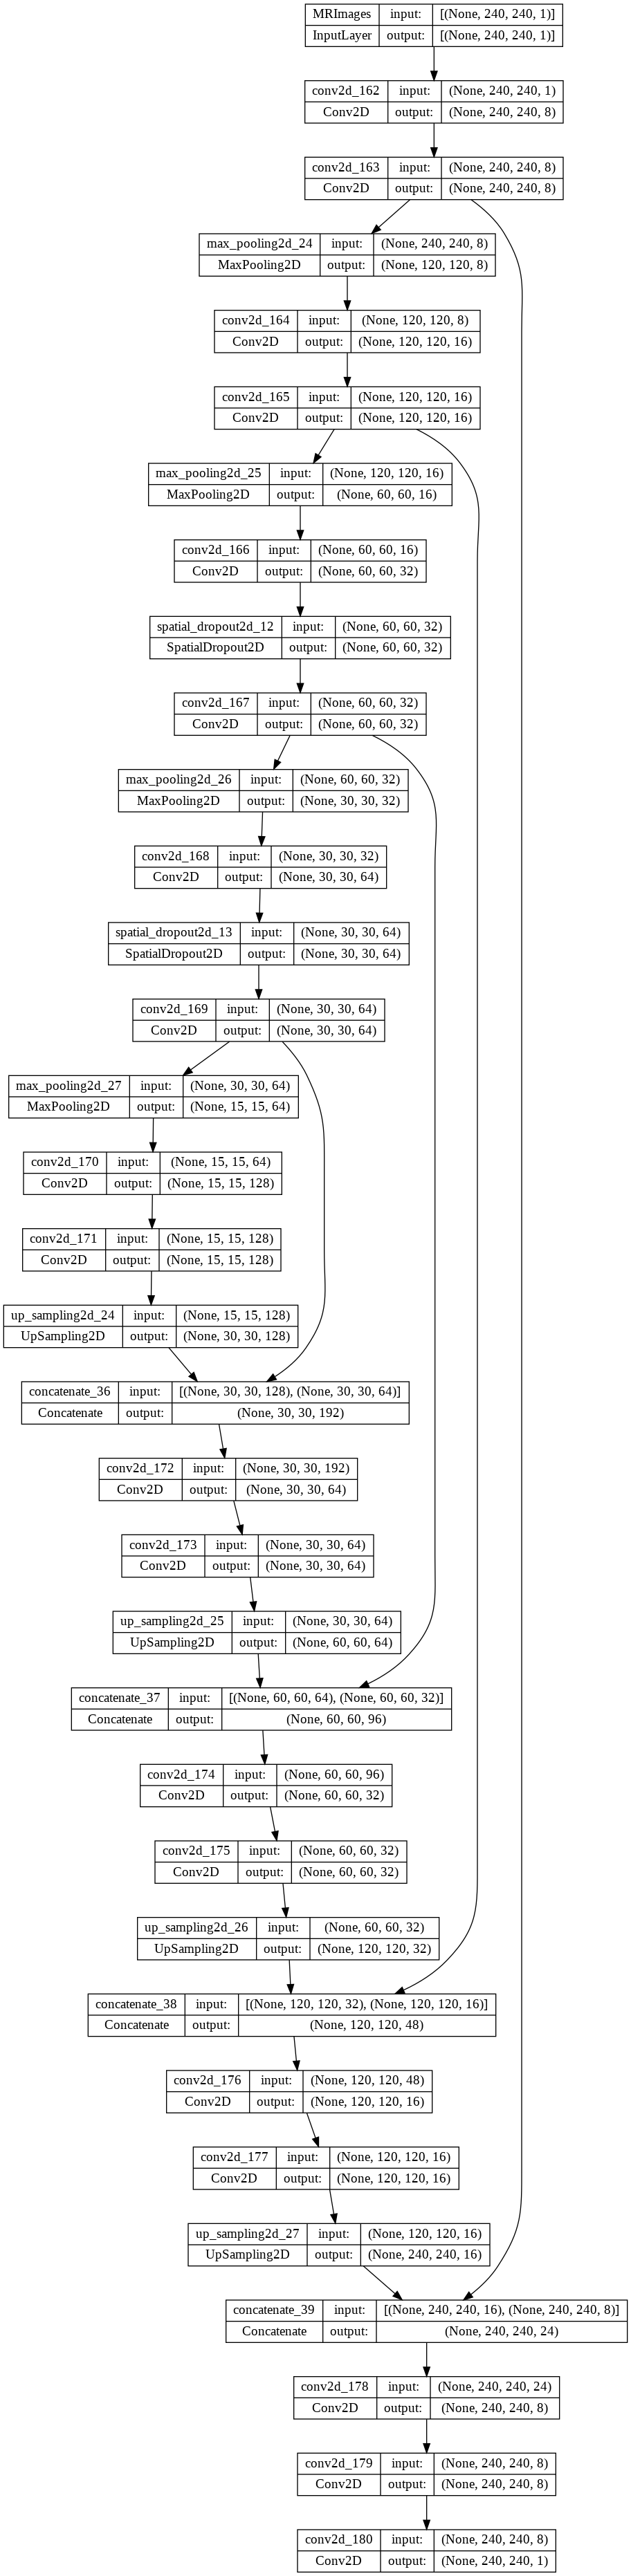

In [ ]:
unet_model1 = unet(fms=8, upsampling_mode=True)

vanilla_unet_upsampling = unet_model1.build_model(ds_train.get_shape()[0], 
                                                   ds_train.get_shape()[1])
plot_model(vanilla_unet_upsampling,
           to_file='/gdrive/My Drive/Kwork/vanilla_unet_upsampling.png',
           show_shapes=True,
           show_layer_names=True,
           rankdir='TB'
            )
Image('/gdrive/My Drive/Kwork/vanilla_unet_upsampling.png')

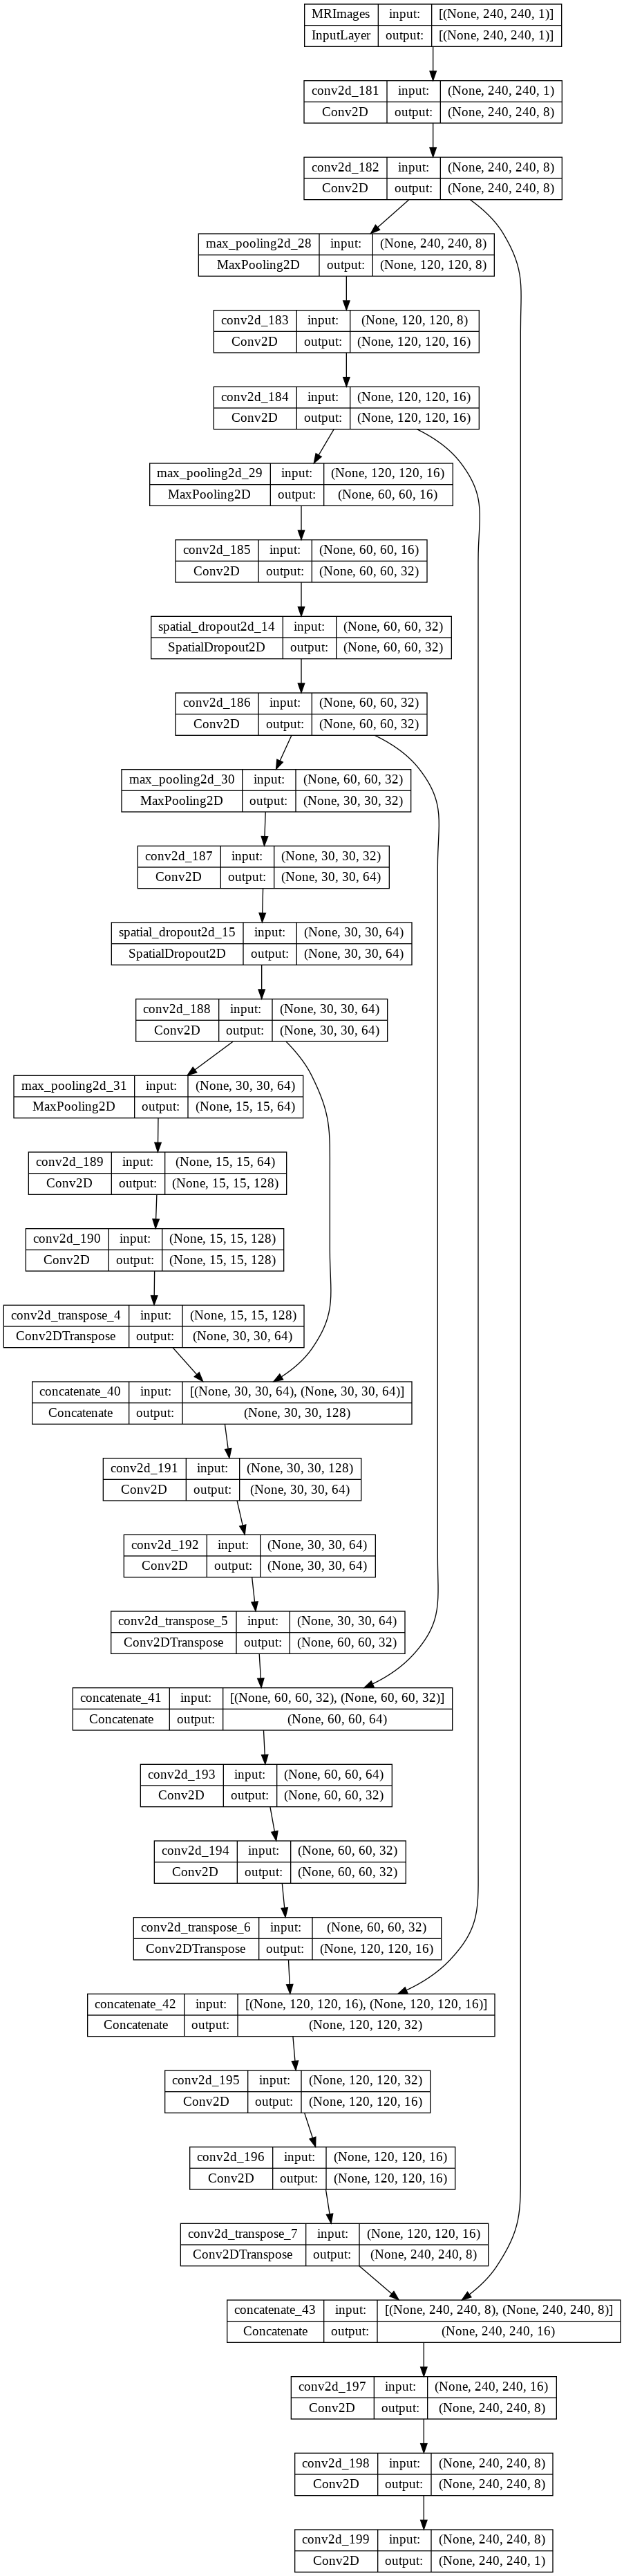

In [ ]:
unet_model2 = unet(fms=8, upsampling_mode=False)

vanilla_unet_transposed = unet_model2.build_model(ds_train.get_shape()[0], 
                                                   ds_train.get_shape()[1])
plot_model(vanilla_unet_transposed,
           to_file='/gdrive/My Drive/Kwork/vanilla_unet_transposed.png',
           show_shapes=True,
           show_layer_names=True,
           rankdir='TB'
            )
Image('/gdrive/My Drive/Kwork/vanilla_unet_transposed.png')

In [ ]:
def DilatedDenseNet(input_shape, features=1, depth=5, padding='same', batchnorm=False, dropout=0.0):
    x = K.layers.Input(shape=input_shape)
    inputs = x

    # get the pattern
    x = K.layers.Conv2D(features, kernel_size=(5,5), padding=padding)(x)

    maps = [inputs]
    dilation_rate = 1
    kernel_size = (3,3)
    for n in range(depth):
        maps.append(x)
        x = K.layers.Concatenate()(maps)
        x = K.layers.BatchNormalization()(x)
        x = K.layers.Activation('relu')(x)
        x = K.layers.Conv2D(features, kernel_size, dilation_rate=dilation_rate,
                   padding=padding)(x)
        dilation_rate *= 2

    # More layers to help with segentation mask
    x = K.layers.Conv2D(features, kernel_size=(3,3), activation='relu', padding=padding)(x)
    x = K.layers.Conv2D(features, kernel_size=(3,3), activation='relu', padding=padding)(x)
    x = K.layers.Conv2D(features, kernel_size=(3,3), activation='relu', padding=padding)(x)

    probabilities = K.layers.Conv2D(2, kernel_size=(1,1), activation='softmax')(x)

    return K.models.Model(inputs=inputs, outputs=probabilities)

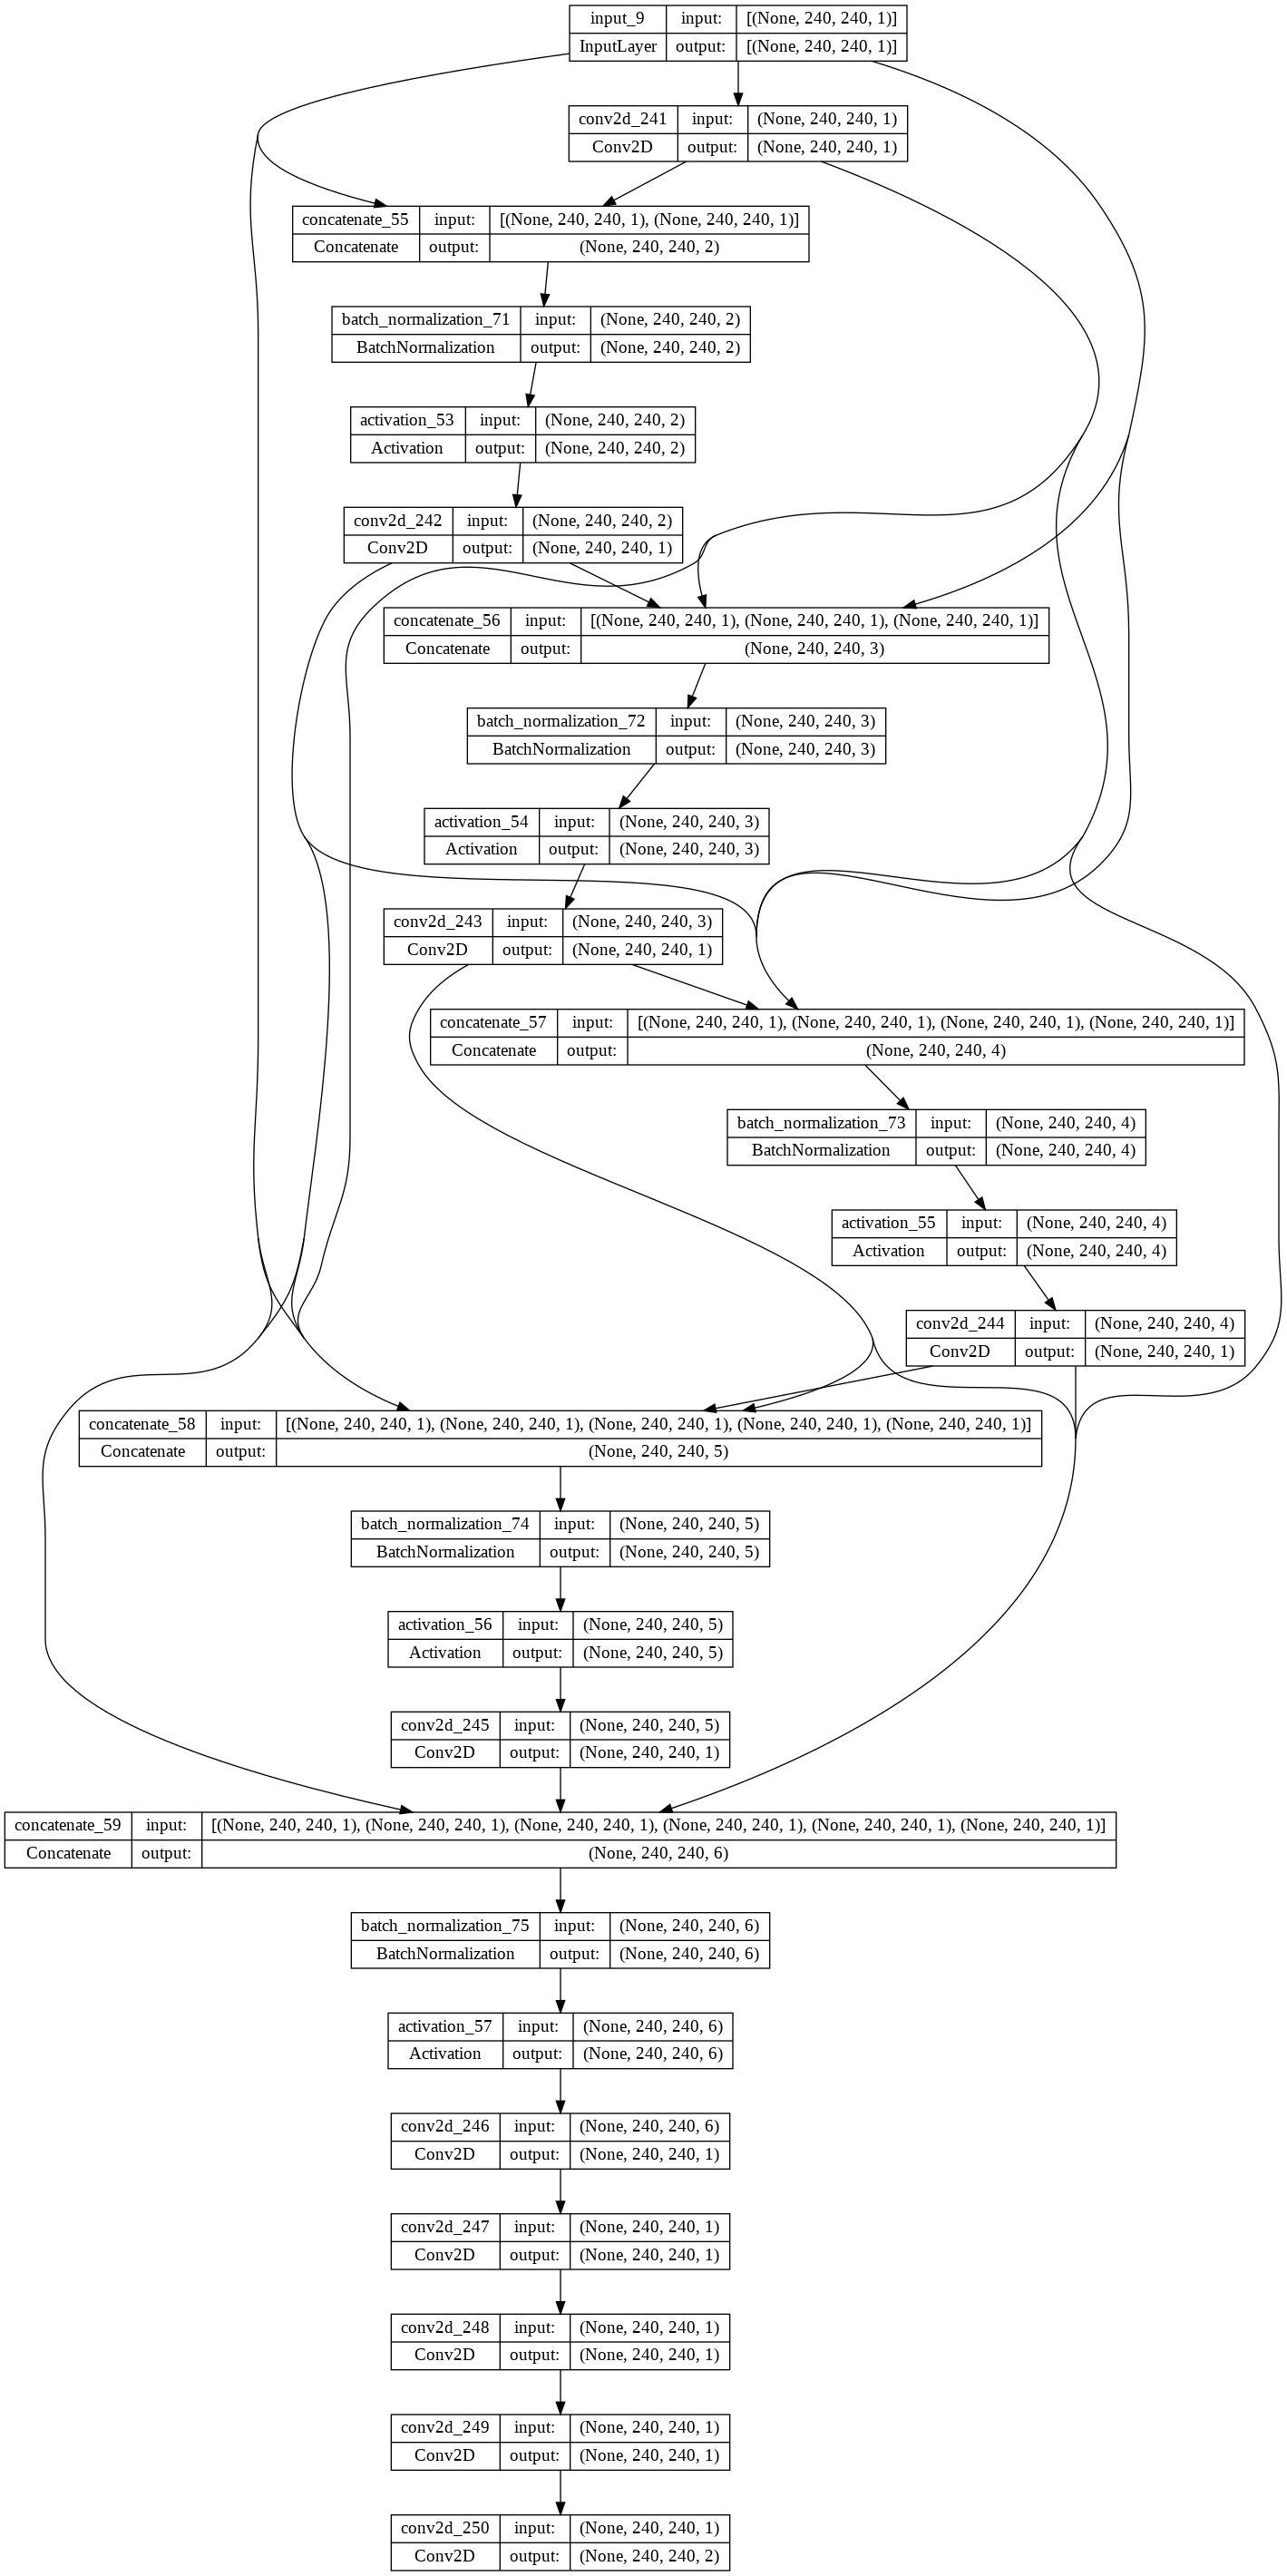

In [ ]:
dd = DilatedDenseNet(input_shape=(240, 240, 1))

plot_model(dd,
           to_file='/gdrive/My Drive/Kwork/dd.png',
           show_shapes=True,
           show_layer_names=True,
           rankdir='TB'
            )
Image('/gdrive/My Drive/Kwork/dd.png')


In [ ]:
# Residual Unet Network made by parts
# Reference: https://www.kaggle.com/code/ekhtiar/resunet-a-baseline-on-tensorflow#Resunet

def bn_act(x, act=True):
    'batch normalization'
    x = tf.keras.layers.BatchNormalization()(x)
    if act == True:
        x = tf.keras.layers.Activation('relu')(x)
    return x

def conv_block(x, filters, kernel_size=3, padding='same', strides=1):
    'convolutional layer'
    conv = bn_act(x)
    conv = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=3, padding='same', strides=1):
    conv = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size, padding, strides)
    shortcut = K.layers.Conv2D(filters, kernel_size=1, padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    output = K.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=3, padding='same', strides=1):
    res = conv_block(x, filters, kernel_size, padding, strides)
    res = conv_block(res, filters, kernel_size, padding, 1)
    shortcut = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    output = K.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = K.layers.UpSampling2D((2,2))(x)
    c = K.layers.Concatenate()([u, xskip])
    return c

def ResUNet(img_h, img_w):
    f = [16, 32, 64, 128, 256]
    inputs = K.layers.Input((img_h, img_w, 1))
    
    ## Encoder part
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bringe between incoder and decoder
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder part
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = tf.keras.layers.Conv2D(4, (1, 1), padding="same", activation="sigmoid")(d4)
    model = tf.keras.models.Model(inputs, outputs)
    return model

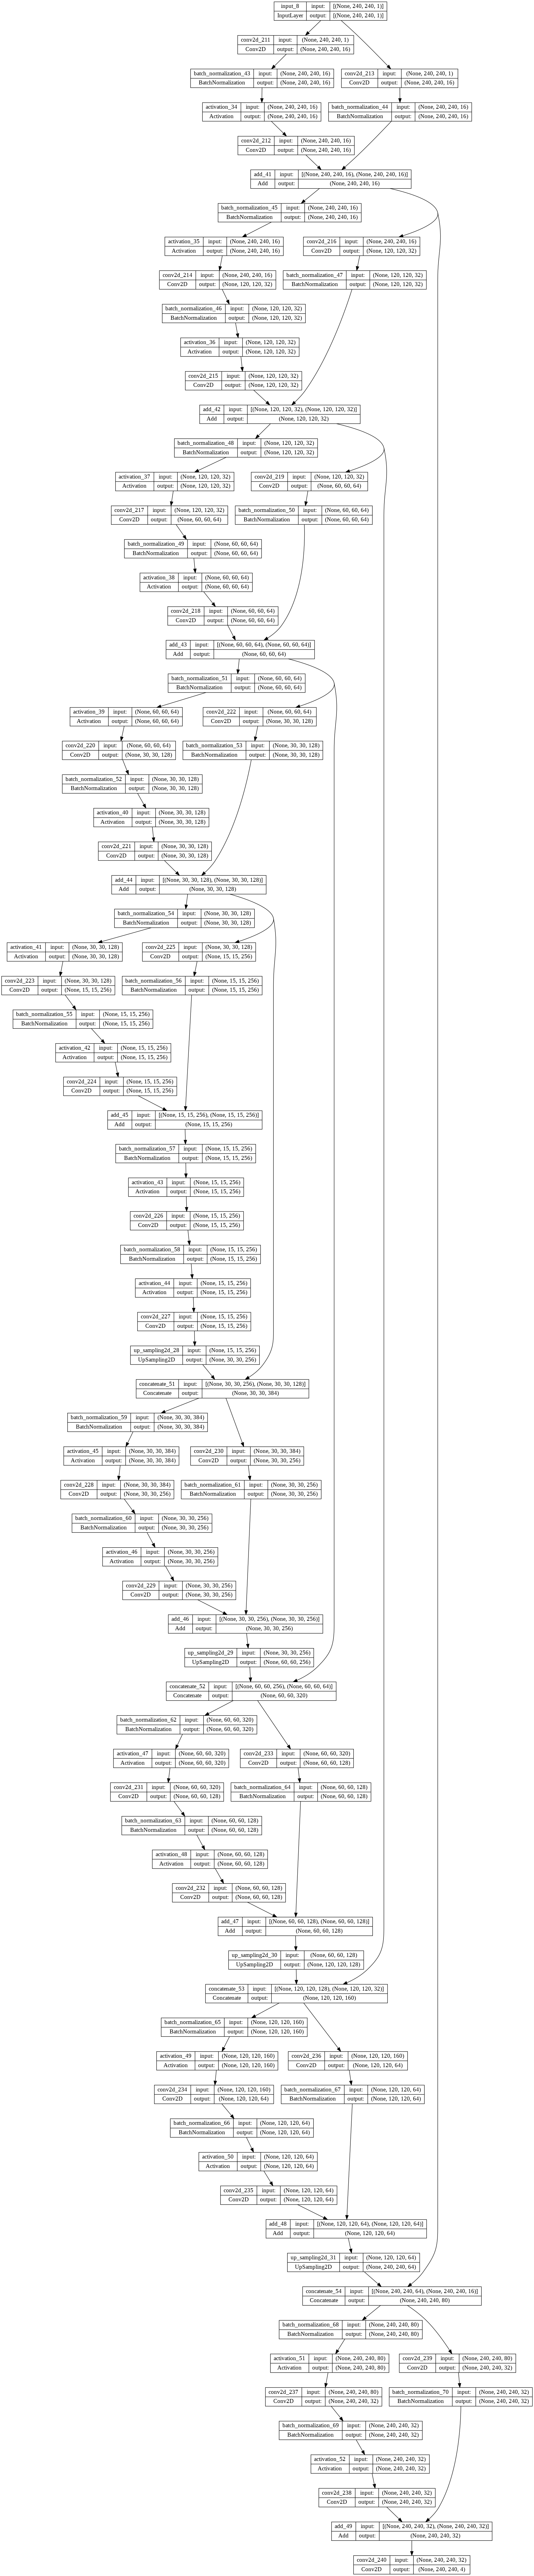

In [ ]:
resunet = ResUNet(img_h=240, img_w=240)

plot_model(resunet,
           to_file='/gdrive/My Drive/Kwork/resunet.png',
           show_shapes=True,
           show_layer_names=True,
           rankdir='TB'
            )
Image('/gdrive/My Drive/Kwork/resunet.png')

## Loss and Metrics

In [ ]:
def dice_coef(target, prediction, axis=(1, 2), smooth=0.0001):
    """
    Dice coefficient: 2 * intersection / union
    Rounding is used
    """
    prediction = K.backend.round(prediction) 
    intersection = tf.reduce_sum(target * prediction, axis=axis)
    union = tf.reduce_sum(target + prediction, axis=axis)
    coef = tf.constant(2.) * intersection + smooth
    coef /= (union + smooth)
    return tf.reduce_mean(coef)

def soft_dice_coef(target, prediction, axis=(1, 2), smooth=0.0001):
    """
    Dice coefficient: 2 * intersection / union
    Rounding is not used
    """
    intersection = tf.reduce_sum(target * prediction, axis=axis)
    union = tf.reduce_sum(target + prediction, axis=axis)
    coef = tf.constant(2.) * intersection + smooth
    coef /= (union + smooth)
    return tf.reduce_mean(coef)


def dice_coef_loss(target, prediction, axis=(1, 2), smooth=0.0001):
    """
    Sorenson (Soft) Dice loss
    Self defined loss to achieve better result
    """
    intersection = tf.reduce_sum(prediction * target, axis=axis)
    p = tf.reduce_sum(prediction, axis=axis)
    t = tf.reduce_sum(target, axis=axis)
    temp1 = tf.reduce_mean(intersection + smooth)
    temp2 = tf.reduce_mean(t + p + smooth)
    loss = -tf.math.log(2.*temp1) + tf.math.log(temp2)
    return loss


## Utils

In [ ]:
from tensorflow import keras as K

In [ ]:
# Define the callbacks during the training
def get_callbacks(save_filename = './checkpoint'):
    """
    callbacks for the training
    """

    # Save best model using validation loss
    model_checkpoint = K.callbacks.ModelCheckpoint(save_filename,
                                                    verbose=1,
                                                    monitor="val_loss",
                                                    save_best_only=True)
    # eatly stop is validation score is not incresing
    early_stopping = K.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

    return [model_checkpoint, early_stopping]

In [ ]:
# Evaluate the model
def evaluate_model(model, ds_test, metrics_names):
    """
    Evaluate the model on the test dataset
    """
    metrics = model.evaluate(ds_test, verbose=2)

    for i, metric in enumerate(metrics):
        print("test dataset evaluation {} = {:.4f}".format(
            metrics_names[i], metric))

In [ ]:
# plot some samples from test dataset and their predictions
def plot_prediction_samples(test, model):
    '''
    label_filename = trainFiles[np.random.randint(0,3)]
    img_filename = label_filename.replace("labelsTr", "imagesTr")
    img = np.array(nib.load(img_filename).dataobj)
    label = np.array(nib.load(label_filename).dataobj)
    #print(image.shape, label.shape)
    plt.figure(figsize=(10,10))
    slice_num = 7

    img = img[:240,:240,slice_num,0]
    mask = label[:240,:240,slice_num]
    '''
    for img, mask in test:
        pred = model.predict(img)
        print(pred.shape)
        pred_t = np.copy(pred)
        pred_t[np.nonzero(pred_t < 0.3)] = 0.0
        pred_t[np.nonzero(pred_t >= 0.3)] = 255.
        pred_t = pred_t.astype("uint8")
        break
    fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))
    ax[0, 0].imshow(img[0, :, :, 0])
    ax[0, 0].set_title("image")
    ax[0, 1].imshow(mask[0, :, :, 0])
    ax[0, 1].set_title("mask")

    ax[1, 0].imshow(pred[0, :, :, 0])
    ax[1, 0].set_title("prediction")
    ax[1, 1].imshow(pred_t[0, :, :, 0])
    ax[1, 1].set_title("prediction with input threshold")

## Train

In [ ]:
metrics = [dice_coef, soft_dice_coef]
metrics_names = ["loss", "dice coefficient", "soft dice coefficient"]
loss = dice_coef_loss
callbacks = get_callbacks()

optimizer = K.optimizers.Adam(lr=1e-4)

vanilla_unet_upsampling.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
start_time = datetime.datetime.now()
num_epoch = 50
history = vanilla_unet_upsampling.fit(ds_train,
              epochs=num_epoch,
              validation_data=ds_validation,
              verbose=1,
              callbacks=callbacks)

print("Training time = {} seconds".format(datetime.datetime.now() - start_time))

Epoch 1/50
62/62 [==============================] - ETA: 0s - loss: 0.8327 - dice_coef: 0.3979 - soft_dice_coef: 0.3748
Epoch 1: val_loss improved from inf to 1.13097, saving model to ./checkpoint


62/62 [==============================] - 12s 170ms/step - loss: 0.8327 - dice_coef: 0.3979 - soft_dice_coef: 0.3748 - val_loss: 1.1310 - val_dice_coef: 0.2863 - val_soft_dice_coef: 0.2857
Epoch 2/50
62/62 [==============================] - ETA: 0s - loss: 0.5419 - dice_coef: 0.5241 - soft_dice_coef: 0.4575
Epoch 2: val_loss improved from 1.13097 to 0.89509, saving model to ./checkpoint


62/62 [==============================] - 8s 122ms/step - loss: 0.5419 - dice_coef: 0.5241 - soft_dice_coef: 0.4575 - val_loss: 0.8951 - val_dice_coef: 0.3911 - val_soft_dice_coef: 0.3901
Epoch 3/50
62/62 [==============================] - ETA: 0s - loss: 0.7112 - dice_coef: 0.4584 - soft_dice_coef: 0.4119
Epoch 3: val_loss improved from 0.89509 to 0.68376, saving model to ./checkpoint


62/62 [==============================] - 9s 141ms/step - loss: 0.7112 - dice_coef: 0.4584 - soft_dice_coef: 0.4119 - val_loss: 0.6838 - val_dice_coef: 0.4061 - val_soft_dice_coef: 0.4046
Epoch 4/50
62/62 [==============================] - ETA: 0s - loss: 0.6450 - dice_coef: 0.4552 - soft_dice_coef: 0.4068
Epoch 4: val_loss did not improve from 0.68376
62/62 [==============================] - 5s 73ms/step - loss: 0.6450 - dice_coef: 0.4552 - soft_dice_coef: 0.4068 - val_loss: 0.9690 - val_dice_coef: 0.3915 - val_soft_dice_coef: 0.3543
Epoch 5/50
62/62 [==============================] - ETA: 0s - loss: 0.6451 - dice_coef: 0.4949 - soft_dice_coef: 0.4320
Epoch 5: val_loss did not improve from 0.68376
62/62 [==============================] - 5s 85ms/step - loss: 0.6451 - dice_coef: 0.4949 - soft_dice_coef: 0.4320 - val_loss: 1.0400 - val_dice_coef: 0.3712 - val_soft_dice_coef: 0.3694
Epoch 6/50
62/62 [==============================] - ETA: 0s - loss: 0.5488 - dice_coef: 0.5354 - soft_dice_

dict_keys(['loss', 'dice_coef', 'soft_dice_coef', 'val_loss', 'val_dice_coef', 'val_soft_dice_coef'])


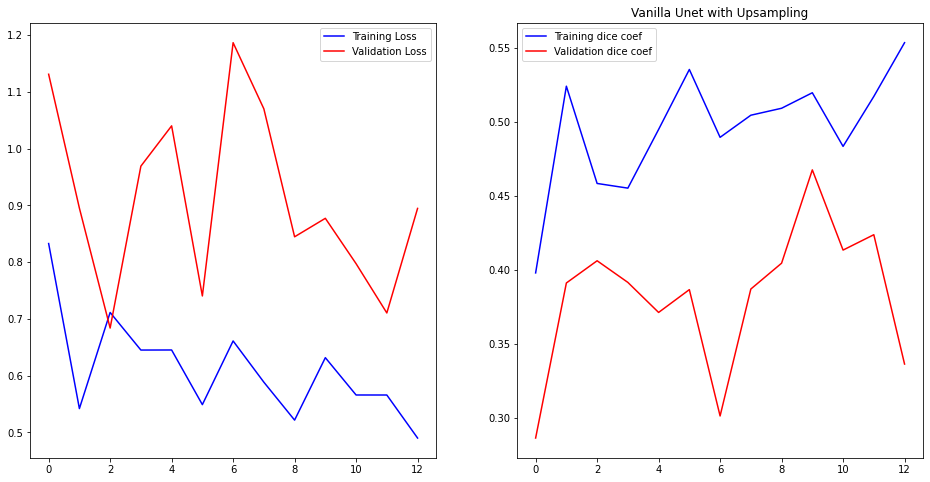

In [ ]:
print(history.history.keys())

hist = history.history

dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

epoch=range(len(dice))

loss=hist['loss']
val_loss=hist['val_loss']


f,ax=plt.subplots(1,2,figsize=(16,8))



ax[0].plot(epoch,loss,'b',label='Training Loss')
ax[0].plot(epoch,val_loss,'r',label='Validation Loss')
ax[0].legend()
plt.title("Vanilla Unet with Upsampling")

ax[1].plot(epoch,dice,'b',label='Training dice coef')
ax[1].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[1].legend()
plt.title("Vanilla Unet with Upsampling")

plt.show()

In [ ]:
metrics = [dice_coef, soft_dice_coef]
metrics_names = ["loss", "dice coefficient", "soft dice coefficient"]
loss = dice_coef_loss
callbacks = get_callbacks()

optimizer = K.optimizers.Adam(lr=1e-4)

vanilla_unet_transposed.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
start_time = datetime.datetime.now()
num_epoch = 50
history = vanilla_unet_transposed.fit(ds_train,
              epochs=num_epoch,
              validation_data=ds_validation,
              verbose=1,
              callbacks=callbacks)

print("Training time = {} seconds".format(datetime.datetime.now() - start_time))

Epoch 1/50
62/62 [==============================] - ETA: 0s - loss: 0.5226 - dice_coef: 0.5456 - soft_dice_coef: 0.4524
Epoch 1: val_loss improved from inf to 1.18260, saving model to ./checkpoint


62/62 [==============================] - 11s 146ms/step - loss: 0.5226 - dice_coef: 0.5456 - soft_dice_coef: 0.4524 - val_loss: 1.1826 - val_dice_coef: 0.3224 - val_soft_dice_coef: 0.3218
Epoch 2/50
62/62 [==============================] - ETA: 0s - loss: 0.5575 - dice_coef: 0.5346 - soft_dice_coef: 0.4211
Epoch 2: val_loss did not improve from 1.18260
62/62 [==============================] - 5s 80ms/step - loss: 0.5575 - dice_coef: 0.5346 - soft_dice_coef: 0.4211 - val_loss: 1.3493 - val_dice_coef: 0.4193 - val_soft_dice_coef: 0.2228
Epoch 3/50
62/62 [==============================] - ETA: 0s - loss: 0.5377 - dice_coef: 0.5364 - soft_dice_coef: 0.4392
Epoch 3: val_loss improved from 1.18260 to 0.53281, saving model to ./checkpoint


62/62 [==============================] - 9s 146ms/step - loss: 0.5377 - dice_coef: 0.5364 - soft_dice_coef: 0.4392 - val_loss: 0.5328 - val_dice_coef: 0.5349 - val_soft_dice_coef: 0.4263
Epoch 4/50
62/62 [==============================] - ETA: 0s - loss: 0.4858 - dice_coef: 0.5555 - soft_dice_coef: 0.4421
Epoch 4: val_loss did not improve from 0.53281
62/62 [==============================] - 5s 73ms/step - loss: 0.4858 - dice_coef: 0.5555 - soft_dice_coef: 0.4421 - val_loss: 0.7202 - val_dice_coef: 0.4260 - val_soft_dice_coef: 0.3538
Epoch 5/50
62/62 [==============================] - ETA: 0s - loss: 0.5160 - dice_coef: 0.5310 - soft_dice_coef: 0.4239
Epoch 5: val_loss did not improve from 0.53281
62/62 [==============================] - 4s 68ms/step - loss: 0.5160 - dice_coef: 0.5310 - soft_dice_coef: 0.4239 - val_loss: 0.7357 - val_dice_coef: 0.4329 - val_soft_dice_coef: 0.4326
Epoch 6/50
62/62 [==============================] - ETA: 0s - loss: 0.5439 - dice_coef: 0.5573 - soft_dice_

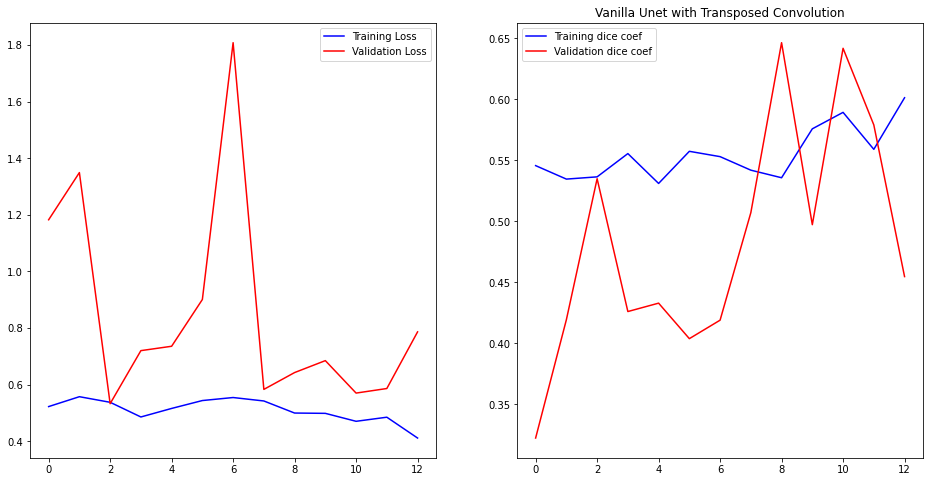

In [ ]:

hist = history.history

dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

epoch=range(len(dice))

loss=hist['loss']
val_loss=hist['val_loss']


f,ax=plt.subplots(1,2,figsize=(16,8))



ax[0].plot(epoch,loss,'b',label='Training Loss')
ax[0].plot(epoch,val_loss,'r',label='Validation Loss')
ax[0].legend()
plt.title("Vanilla Unet with Upsampling")

ax[1].plot(epoch,dice,'b',label='Training dice coef')
ax[1].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[1].legend()
plt.title("Vanilla Unet with Transposed Convolution")

plt.show()

In [ ]:
metrics = [dice_coef, soft_dice_coef]
metrics_names = ["loss", "dice coefficient", "soft dice coefficient"]
loss = dice_coef_loss
callbacks = get_callbacks()

optimizer = K.optimizers.Adam(lr=1e-4)

resunet.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
start_time = datetime.datetime.now()
num_epoch = 20
history = resunet.fit(ds_train,
              epochs=num_epoch,
              validation_data=ds_validation,
              verbose=1,
              callbacks=callbacks)

print("Training time = {} seconds".format(datetime.datetime.now() - start_time))

Epoch 1/20
62/62 [==============================] - ETA: 0s - loss: 0.3476 - dice_coef: 0.6599 - soft_dice_coef: 0.5239
Epoch 1: val_loss improved from inf to 0.76327, saving model to ./checkpoint


62/62 [==============================] - 30s 439ms/step - loss: 0.3476 - dice_coef: 0.6599 - soft_dice_coef: 0.5239 - val_loss: 0.7633 - val_dice_coef: 0.4689 - val_soft_dice_coef: 0.4584
Epoch 2/20
62/62 [==============================] - ETA: 0s - loss: 0.3836 - dice_coef: 0.6098 - soft_dice_coef: 0.4922
Epoch 2: val_loss did not improve from 0.76327
62/62 [==============================] - 16s 250ms/step - loss: 0.3836 - dice_coef: 0.6098 - soft_dice_coef: 0.4922 - val_loss: 1.7173 - val_dice_coef: 0.1707 - val_soft_dice_coef: 0.1705
Epoch 3/20
62/62 [==============================] - ETA: 0s - loss: 0.3063 - dice_coef: 0.6854 - soft_dice_coef: 0.5186
Epoch 3: val_loss did not improve from 0.76327
62/62 [==============================] - 16s 250ms/step - loss: 0.3063 - dice_coef: 0.6854 - soft_dice_coef: 0.5186 - val_loss: 0.7671 - val_dice_coef: 0.4087 - val_soft_dice_coef: 0.3593
Epoch 4/20
62/62 [==============================] - ETA: 0s - loss: 0.3120 - dice_coef: 0.6830 - soft_

62/62 [==============================] - 26s 424ms/step - loss: 0.3120 - dice_coef: 0.6830 - soft_dice_coef: 0.5490 - val_loss: 0.3378 - val_dice_coef: 0.5814 - val_soft_dice_coef: 0.5081
Epoch 5/20
62/62 [==============================] - ETA: 0s - loss: 0.2671 - dice_coef: 0.6984 - soft_dice_coef: 0.5695
Epoch 5: val_loss did not improve from 0.33779
62/62 [==============================] - 15s 246ms/step - loss: 0.2671 - dice_coef: 0.6984 - soft_dice_coef: 0.5695 - val_loss: 0.5170 - val_dice_coef: 0.5579 - val_soft_dice_coef: 0.4303
Epoch 6/20
62/62 [==============================] - ETA: 0s - loss: 0.3481 - dice_coef: 0.6452 - soft_dice_coef: 0.5212
Epoch 6: val_loss did not improve from 0.33779
62/62 [==============================] - 16s 253ms/step - loss: 0.3481 - dice_coef: 0.6452 - soft_dice_coef: 0.5212 - val_loss: 0.6235 - val_dice_coef: 0.4923 - val_soft_dice_coef: 0.3848
Epoch 7/20
62/62 [==============================] - ETA: 0s - loss: 0.2872 - dice_coef: 0.6784 - soft_

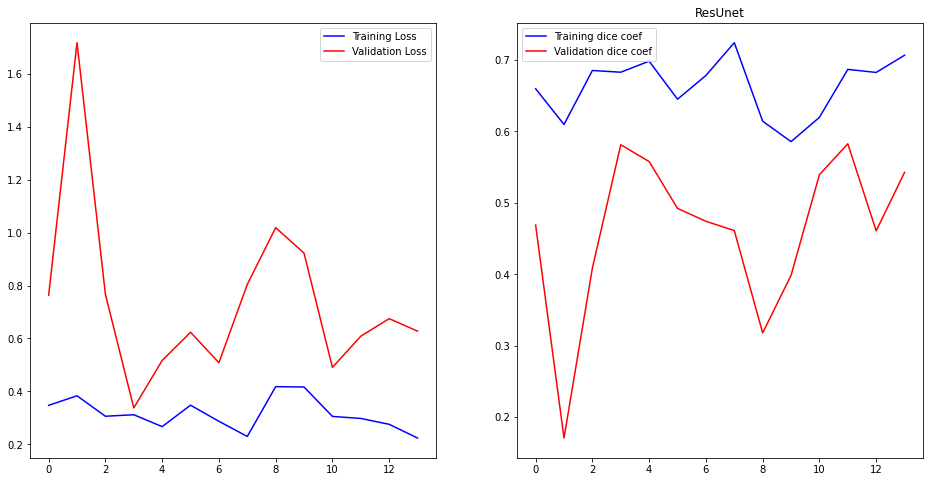

In [ ]:

hist = history.history

dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

epoch=range(len(dice))

loss=hist['loss']
val_loss=hist['val_loss']


f,ax=plt.subplots(1,2,figsize=(16,8))



ax[0].plot(epoch,loss,'b',label='Training Loss')
ax[0].plot(epoch,val_loss,'r',label='Validation Loss')
ax[0].legend()
plt.title("Vanilla Unet with Upsampling")

ax[1].plot(epoch,dice,'b',label='Training dice coef')
ax[1].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[1].legend()
plt.title("ResUnet")

plt.show()

In [ ]:
metrics = [dice_coef, soft_dice_coef]
metrics_names = ["loss", "dice coefficient", "soft dice coefficient"]
loss = dice_coef_loss

callbacks = get_callbacks()

optimizer = K.optimizers.Adam(lr=3e-4)

dd.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
start_time = datetime.datetime.now()
num_epoch = 15
history = dd.fit(ds_train,
              epochs=num_epoch,
              validation_data=ds_validation,
              verbose=1,
              callbacks=callbacks)

print("Training time = {} seconds".format(datetime.datetime.now() - start_time))

Epoch 1/15
62/62 [==============================] - ETA: 0s - loss: 2.7828 - dice_coef: 0.1393 - soft_dice_coef: 0.0717
Epoch 1: val_loss improved from inf to 2.91435, saving model to ./checkpoint


62/62 [==============================] - 11s 150ms/step - loss: 2.7828 - dice_coef: 0.1393 - soft_dice_coef: 0.0717 - val_loss: 2.9144 - val_dice_coef: 0.1515 - val_soft_dice_coef: 0.0618
Epoch 2/15
62/62 [==============================] - ETA: 0s - loss: 2.6473 - dice_coef: 0.1266 - soft_dice_coef: 0.0812
Epoch 2: val_loss did not improve from 2.91435
62/62 [==============================] - 4s 66ms/step - loss: 2.6473 - dice_coef: 0.1266 - soft_dice_coef: 0.0812 - val_loss: 3.1840 - val_dice_coef: 0.1738 - val_soft_dice_coef: 0.0504
Epoch 3/15
62/62 [==============================] - ETA: 0s - loss: 2.7549 - dice_coef: 0.1435 - soft_dice_coef: 0.0756
Epoch 3: val_loss did not improve from 2.91435
62/62 [==============================] - 4s 69ms/step - loss: 2.7549 - dice_coef: 0.1435 - soft_dice_coef: 0.0756 - val_loss: 3.2543 - val_dice_coef: 0.2175 - val_soft_dice_coef: 0.0483
Epoch 4/15
62/62 [==============================] - ETA: 0s - loss: 2.7196 - dice_coef: 0.1471 - soft_dice

62/62 [==============================] - 7s 113ms/step - loss: 2.7213 - dice_coef: 0.1342 - soft_dice_coef: 0.0801 - val_loss: 2.7693 - val_dice_coef: 0.1345 - val_soft_dice_coef: 0.0632
Epoch 11/15
62/62 [==============================] - ETA: 0s - loss: 2.6028 - dice_coef: 0.1136 - soft_dice_coef: 0.0831
Epoch 11: val_loss did not improve from 2.76930
62/62 [==============================] - 4s 67ms/step - loss: 2.6028 - dice_coef: 0.1136 - soft_dice_coef: 0.0831 - val_loss: 3.1884 - val_dice_coef: 0.1915 - val_soft_dice_coef: 0.0519
Epoch 12/15
62/62 [==============================] - ETA: 0s - loss: 2.7564 - dice_coef: 0.1402 - soft_dice_coef: 0.0730
Epoch 12: val_loss did not improve from 2.76930
62/62 [==============================] - 4s 66ms/step - loss: 2.7564 - dice_coef: 0.1402 - soft_dice_coef: 0.0730 - val_loss: 3.2857 - val_dice_coef: 0.2169 - val_soft_dice_coef: 0.0477
Epoch 13/15
62/62 [==============================] - ETA: 0s - loss: 2.7701 - dice_coef: 0.1543 - soft_

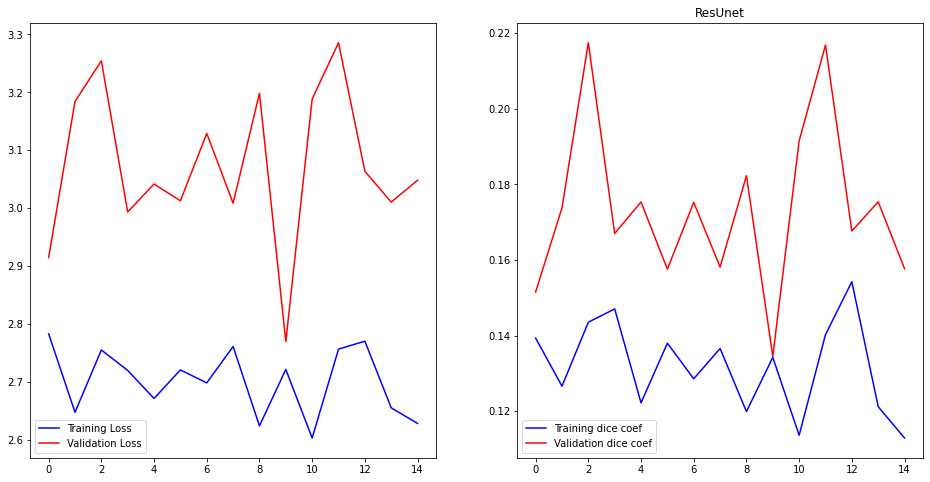

In [ ]:
hist = history.history

dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

epoch=range(len(dice))

loss=hist['loss']
val_loss=hist['val_loss']


f,ax=plt.subplots(1,2,figsize=(16,8))



ax[0].plot(epoch,loss,'b',label='Training Loss')
ax[0].plot(epoch,val_loss,'r',label='Validation Loss')
ax[0].legend()
plt.title("Vanilla Unet with Upsampling")

ax[1].plot(epoch,dice,'b',label='Training dice coef')
ax[1].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[1].legend()
plt.title("ResUnet")

plt.show()

## Evaluate

In [ ]:
evaluate_model(vanilla_unet_upsampling, ds_test, metrics_names)

7/7 - 0s - loss: 0.3524 - dice_coef: 0.6034 - soft_dice_coef: 0.6022 - 363ms/epoch - 52ms/step
test dataset evaluation loss = 0.3524
test dataset evaluation dice coefficient = 0.6034
test dataset evaluation soft dice coefficient = 0.6022


1/1 [==============================] - 0s 179ms/step
(8, 240, 240, 1)


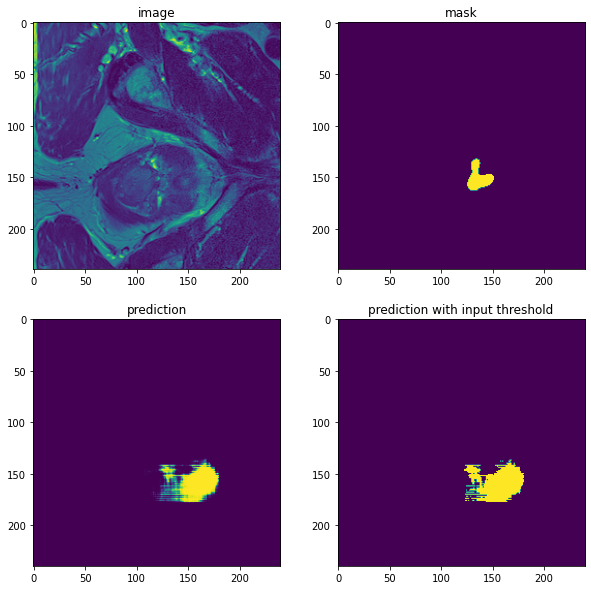

In [ ]:
plot_prediction_samples(ds_test, vanilla_unet_upsampling)

In [ ]:
evaluate_model(vanilla_unet_transposed, ds_test, metrics_names)

7/7 - 0s - loss: 0.2954 - dice_coef: 0.7317 - soft_dice_coef: 0.6768 - 382ms/epoch - 55ms/step
test dataset evaluation loss = 0.2954
test dataset evaluation dice coefficient = 0.7317
test dataset evaluation soft dice coefficient = 0.6768


1/1 [==============================] - 0s 230ms/step
(8, 240, 240, 1)


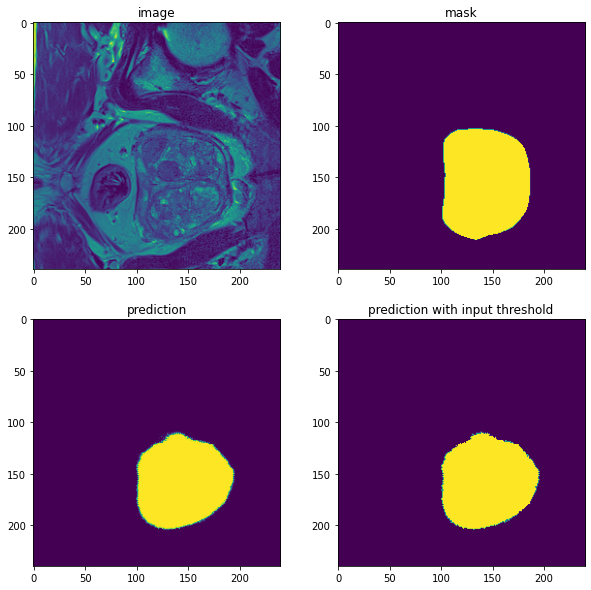

In [ ]:
plot_prediction_samples(ds_test, vanilla_unet_transposed)

In [ ]:
evaluate_model(resunet, ds_test, metrics_names)

7/7 - 1s - loss: 0.8070 - dice_coef: 0.4580 - soft_dice_coef: 0.4068 - 629ms/epoch - 90ms/step
test dataset evaluation loss = 0.8070
test dataset evaluation dice coefficient = 0.4580
test dataset evaluation soft dice coefficient = 0.4068


1/1 [==============================] - 0s 28ms/step
(8, 240, 240, 4)


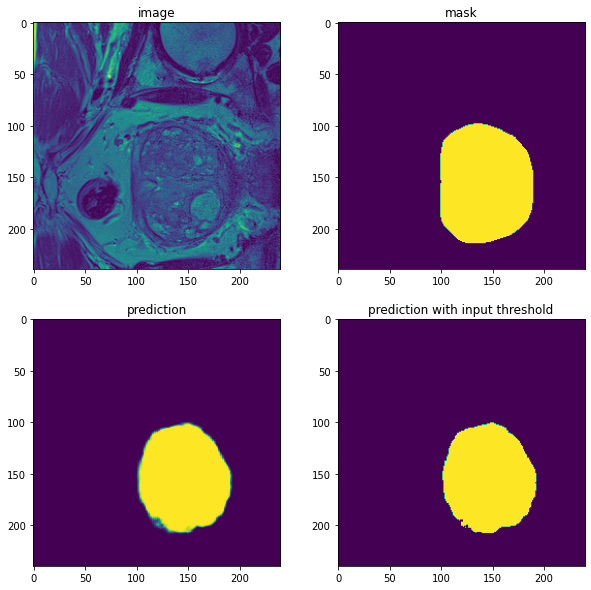

In [ ]:
plot_prediction_samples(ds_test, resunet)

In [ ]:
evaluate_model(dd, ds_test, metrics_names)

7/7 - 0s - loss: 2.2179 - dice_coef: 0.0814 - soft_dice_coef: 0.1230 - 343ms/epoch - 49ms/step
test dataset evaluation loss = 2.2179
test dataset evaluation dice coefficient = 0.0814
test dataset evaluation soft dice coefficient = 0.1230


1/1 [==============================] - 0s 20ms/step
(8, 240, 240, 2)


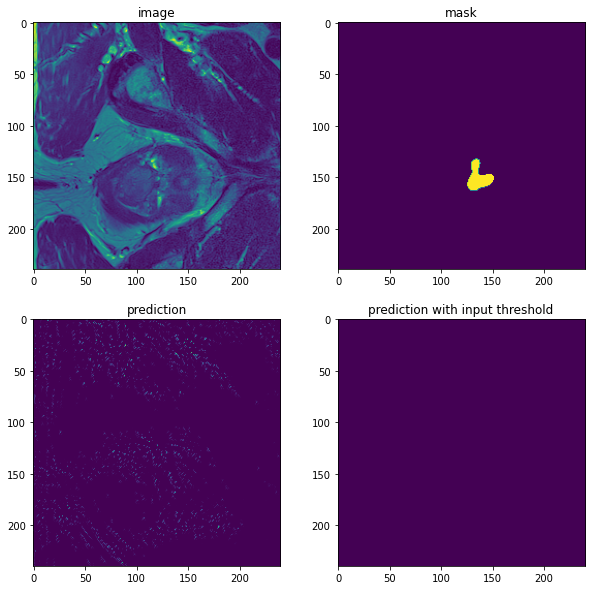

In [ ]:
plot_prediction_samples(ds_test, dd)